# Final Project: Model Code
### Nasiba Adilova, Heather Leighton-Dick, Madison Massie

In [3]:
#libraries/modules
import imblearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from collections import Counter

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC as svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

## Importing the Dataset, Cleaning, Renaming Columns

In [4]:
df_glass = pd.read_csv('glass (1).csv')

df_glass.rename(columns = {'RI':'RIRefractive index', 'Na':'NaSodium', 'Mg': 'MGMagnesium', 'Al': 'AlAluminum', 'Si': 'SiSilicon', 'K':'KPotassium', 'Ca':'CaCalcium','Ba': 'BaBarium', 'Fe': 'FeIron' }, inplace = True)
df_glass

,RIRefractive index,NaSodium,MGMagnesium,AlAluminum,SiSilicon,KPotassium,CaCalcium,BaBarium,FeIron,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


### Imbalanced Dataset

In [10]:
#There are no observations of Type 4 Glass in this dataset
df_glass['Type'].unique()

array([1, 2, 3, 5, 6, 7])

In [12]:
#How many observations of each Type are in the dataset?
df_glass['Type'].value_counts(sort=False)

1    70
2    76
3    17
5    13
6     9
7    29
Name: Type, dtype: int64

### Finding the Allowable Range of Chemical Amounts in Each Type of Glass ("unit measurement: weight percent in corresponding oxide", per dataset specifications)

In [86]:
#Sodium
sodiumrange_bytype = df_glass.groupby('Type').apply(lambda x: x.NaSodium.max() - x.NaSodium.min())
print(sodiumrange_bytype)

Type
1    2.32
2    4.13
3    2.16
5    2.98
6    3.59
7    3.84
dtype: float64


In [77]:
#Magnesium
magrange_bytype = df_glass.groupby('Type').apply(lambda x: x.MGMagnesium.max() - x.MGMagnesium.min())
print(magrange_bytype)

Type
1    1.78
2    3.98
3    0.56
5    2.68
6    2.41
7    3.34
dtype: float64


In [78]:
#Aluminum
alumrange_bytype = df_glass.groupby('Type').apply(lambda x: x.AlAluminum.max() - x.AlAluminum.min())
print(alumrange_bytype)

Type
1    1.40
2    1.56
3    1.18
5    2.10
6    1.75
7    1.69
dtype: float64


In [79]:
#Silicon
sirange_bytype = df_glass.groupby('Type').apply(lambda x: x.SiSilicon.max() - x.SiSilicon.min())
print(sirange_bytype)

Type
1    2.35
2    4.64
3    1.65
5    3.99
6    3.04
7    4.92
dtype: float64


In [80]:
#Potassium
Krange_by_type = df_glass.groupby('Type').apply(lambda x: x.KPotassium.max() - x.KPotassium.min())
print(Krange_by_type)

Type
1    0.69
2    1.10
3    0.61
5    6.08
6    0.00
7    2.70
dtype: float64


In [82]:
#Calcium
CArange_by_type = df_glass.groupby('Type').apply(lambda x: x.CaCalcium.max() - x.CaCalcium.min())
print(Carange_by_type)

Type
1    2.39
2    9.11
3    1.33
5    6.63
6    4.57
7    4.33
dtype: float64


In [84]:
#Iron
FErange_by_type = df_glass.groupby('Type').apply(lambda x: x.FeIron.max() - x.FeIron.min())
print(FErange_by_type)

Type
1    0.31
2    0.35
3    0.37
5    0.51
6    0.00
7    0.09
dtype: float64


In [85]:
#Barium
BArange_by_type = df_glass.groupby('Type').apply(lambda x: x.BaBarium.max() - x.BaBarium.min())
print(BArange_by_type)

Type
1    0.69
2    3.15
3    0.15
5    2.20
6    0.00
7    2.88
dtype: float64


## Applying SMOTE

In [28]:
#SMOTE
data = df_glass.values
# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

## Train Test Split and Standard Scaling

In [29]:
#split into train test split portions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
#Performing Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
## Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

## Training SVM Model Candidates (Linear, Radial Basis Function, Polynomial Kernel)

### Linear Kernel Model

In [64]:
# training a linear SVM classifier
svm_linmodel = SVC(kernel = 'linear', C = 1)
svm_linmodel.fit(X_train, y_train)
svm_linpredictions = svm_linmodel.predict(X_test)
 
#print accuracy and F1 score:
lin_accuracy = svm_linmodel.score(X_test, y_test)
print("Accuracy (Linear Kernel): ", "%.2f" % (lin_accuracy*100)) 
lin_f1 = f1_score(y_test, svm_linpredictions, average='weighted')
print('F1 (Linear Kernel): ', "%.2f" % (lin_f1*100))

Accuracy (Linear Kernel):  83.70
F1 (Linear Kernel):  83.52


In [87]:
print(classification_report(y_test, svm_linpredictions))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.77      0.53      0.62        19
           2       0.53      1.00      0.69        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.84        92
   macro avg       0.85      0.86      0.84        92
weighted avg       0.86      0.84      0.84        92



### Radial Basis Function Model

In [65]:
#training an RBF classifier:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=1).fit(X_train, y_train)
rbf_pred = rbf.predict(X_test)

#printing accuracy and F1 scores:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  86.96
F1 (RBF Kernel):  86.92


In [88]:
print(classification_report(y_test, rbf_pred))

              precision    recall  f1-score   support

           0       0.85      0.65      0.73        17
           1       0.79      0.79      0.79        19
           2       0.64      0.90      0.75        10
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       0.94      0.94      0.94        18

    accuracy                           0.87        92
   macro avg       0.87      0.88      0.87        92
weighted avg       0.88      0.87      0.87        92



### Polynomial Kernel Model

In [66]:
#training a Polynomial classifer:
poly = svm.SVC(kernel='poly', degree=3, C=10).fit(X_train, y_train)
poly_pred = poly.predict(X_test)

#printing accuracy and F1 scores:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial kernel):  78.26
F1 (Polynomial kernel):  78.63


In [89]:
print(classification_report(y_test, poly_pred))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        17
           1       0.78      0.37      0.50        19
           2       0.38      0.90      0.53        10
           3       1.00      0.93      0.96        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        18

    accuracy                           0.78        92
   macro avg       0.82      0.81      0.78        92
weighted avg       0.85      0.78      0.79        92



In [ ]:
### Conclusion: The RBF Kernel method gave the best score of the three SVM models, with an accuracy of 86.96. 
### RBF is the default SVM model, and uses C and gamma parameters

## Plotting Refractive Index v Chemical Components

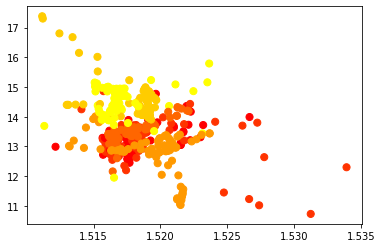

In [68]:
#refractive index v sodium
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

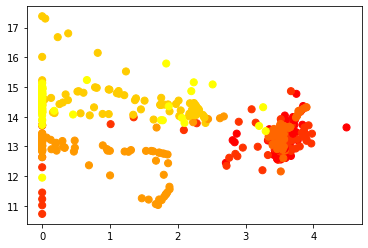

In [75]:
#refractive index v magnesium
plt.scatter(X[:, 2], X[:, 1], c=y, s=50, cmap='autumn');

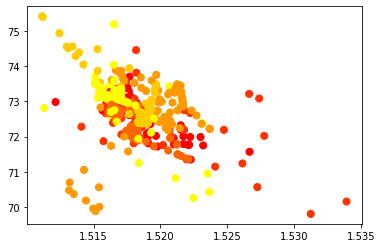

In [70]:
#refractive index v silicon
plt.scatter(X[:, 0], X[:, 4], c=y, s=50, cmap='autumn');

## Confusion Matrices for Each Model

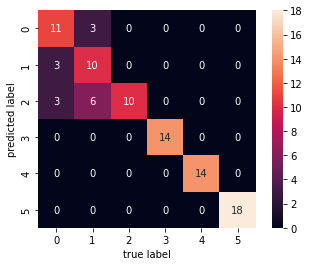

In [94]:
#Confusion matrix for Linear Kernel model
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, svm_linpredictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');



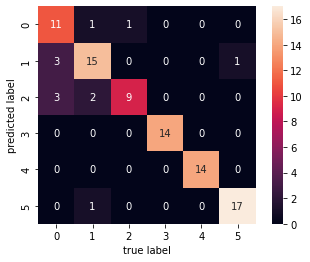

In [95]:
#Confusion Matrix for RBF model
mat = confusion_matrix(y_test, rbf_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

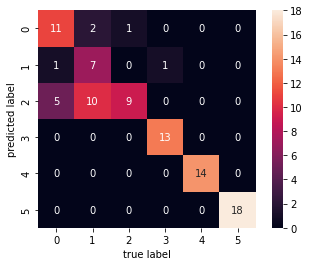

In [96]:
#Confusion Matrix for Polynomial Kernel model
mat = confusion_matrix(y_test, poly_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Plotting the SVM RBF Model

In [91]:
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d
r = np.exp(-(X ** 2).sum(1))

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

## ROC Curves for the RBF Model

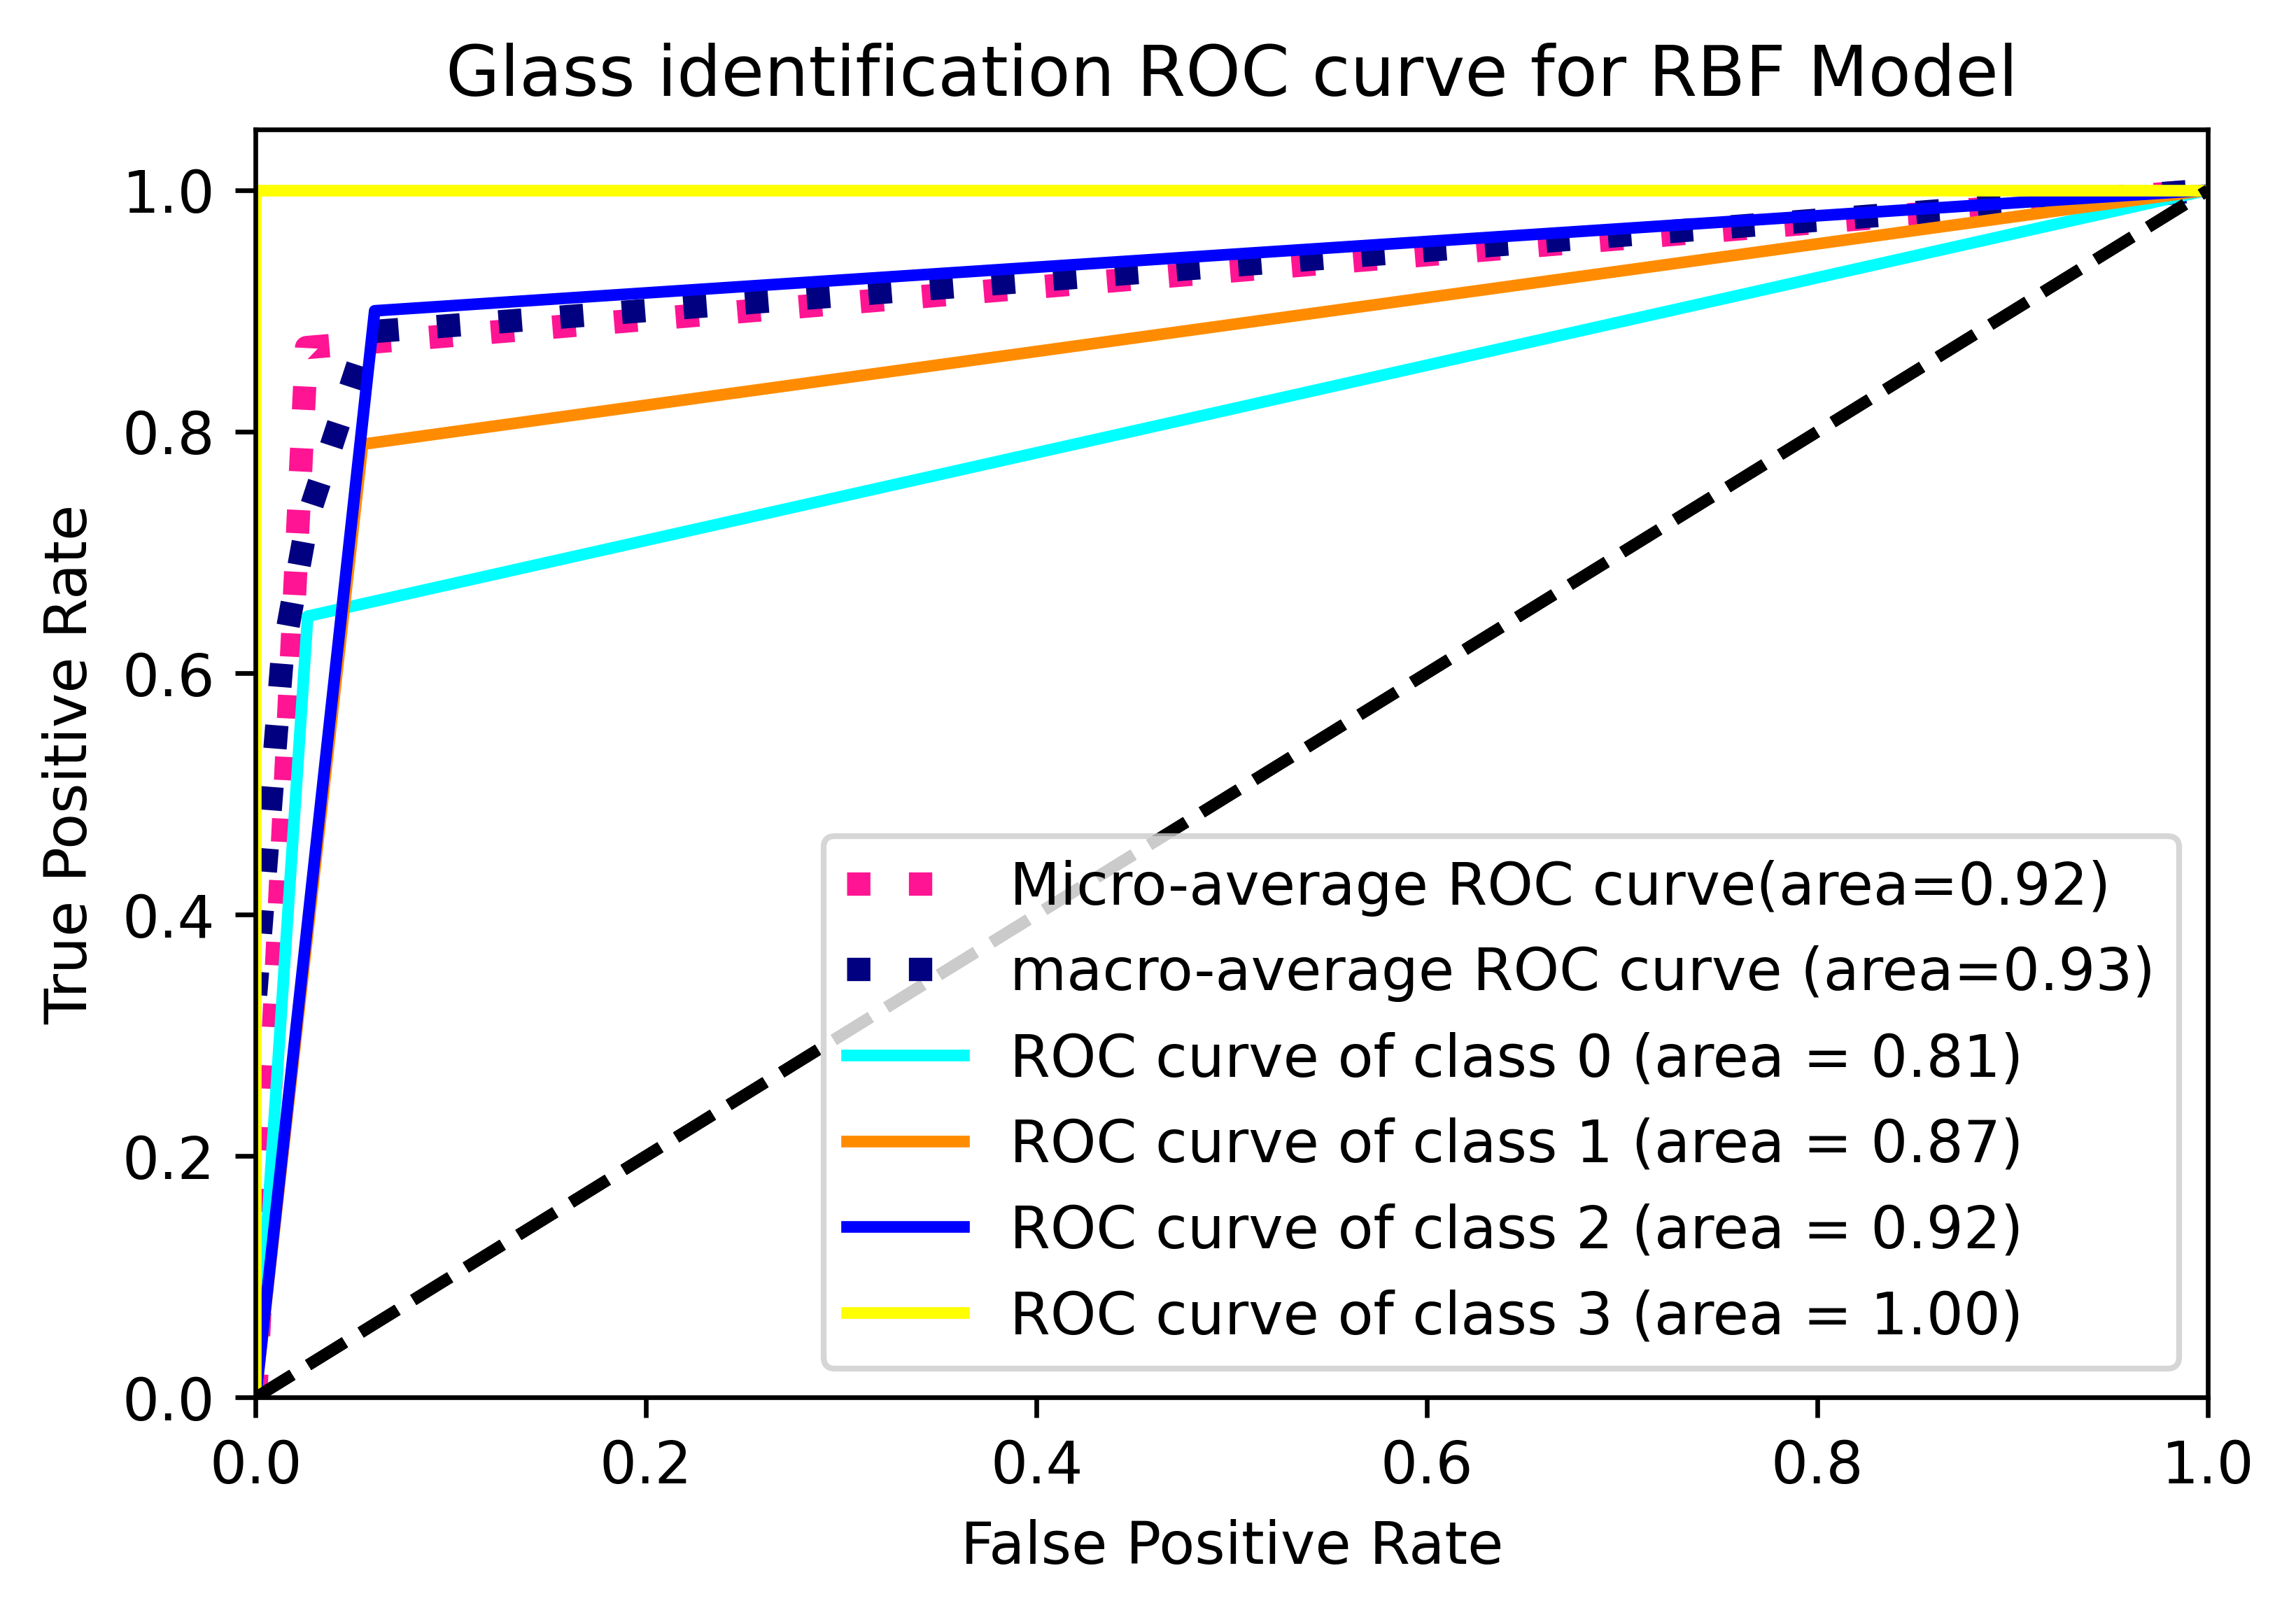

In [127]:
#ROC function and plotting courtesy of Nasiba
def plot_roc_curve(y_test,rbf_pred):
    num_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test,classes =np.arange(num_classes))
    rbf_pred = label_binarize(rbf_pred,classes=np.arange(num_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i],tpr[i],_ = roc_curve(y_test[:, i],rbf_pred[:, i])
        roc_auc[i] = auc(fpr[i],tpr[i])
        
        
    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'],_ = roc_curve(y_test.ravel(),rbf_pred.ravel())
    roc_auc['micro'] = auc(fpr['micro'],tpr['micro'])
    
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr +=np.interp(all_fpr,fpr[i], tpr[i])
        
        
    # Finally average it and compute AUC
    mean_tpr/=num_classes
    
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'],tpr['macro'])
    
    # Plot all ROC curves
    # plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr['micro'],tpr['micro'],
            label = 'Micro-average ROC curve(area={0:0.2f})'.format(roc_auc['micro']),
            color = 'deeppink', linestyle=':', linewidth=4,)
    
    plt.plot(fpr['macro'],tpr['macro'],
            label = 'macro-average ROC curve (area={0:0.2f})'.format(roc_auc['macro']),
            color='navy', linestyle=':',linewidth=4,)
    
    colors = ['aqua','darkorange','blue', 'yellow']
    for i, color in zip(range(num_classes),colors):
        plt.plot(fpr[i],tpr[i],color=color,lw=lw,
                label = 'ROC curve of class {0} (area = {1:0.2f})'.format(i,roc_auc[i]),)
        
        
        plt.plot([0,1],[0,1], 'k--',lw =lw)
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Glass identification ROC curve for RBF Model')
        plt.legend()

plot_roc_curve(y_test,rbf_pred)

NameError: name 'make_meshgrid' is not defined

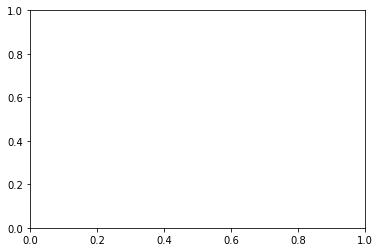

In [99]:
X = X_test [:, :2] 
y = svm_predictions


fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, svm_model_linear, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

# -Insert---------Madison's code and plots---------------

# -Insert---------Nasiba's code and plots---------------